# MPlots
Jugando con los MatrixProfile & MPlots comenzando con el tutorial de Stumpy
https://stumpy.readthedocs.io/en/latest/Tutorial_The_Matrix_Profile.html

In [1]:
import numpy as np
import dvats.memory as mem
import dvats.mplots as mp

In [2]:
mps = mp.MatrixProfiles()

In [3]:
#Common
mps.data = np.random.rand(10000)
mps.subsequence_len = 50
print("Ts ~ ", mps.data.shape)
print("Expected mp length: ", int(np.floor(mps.data.shape[0]-mps.subsequence_len+1)))

Ts ~  (10000,)
Expected mp length:  9951


In [4]:
# Compute & Save Matrix Profile using both stumpy.stump & scamp
mps.compute('stump',  True, True, True)
print("Total MPs: ", len(mps.matrix_profiles))
print(mps.matrix_profiles[0])
mps.compute('scamp',  True, True, True)
print("Total MPs: ", len(mps.matrix_profiles))
print(mps.matrix_profiles[1])

Subsequence len:  50
--> matrix profile
--> Stump


/usr/local/share/miniconda3/envs/env/lib/python3.10/site-packages/numba/cuda/dispatcher.py:536: NumbaPerformanceWarning: Grid size 20 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


matrix profile 5.219902992248535 seconds -->
MPs | compute -> Subsequence len out:  50
MPs | compute -> Subsequence len inside:  50
Total MPs:  1
MP: [6.874787207896456 6.9449614155901465 6.864743931484566 ...
 7.150485765622176 7.187080547969525 6.982264023820207]
Ids: [6868 6869 6870 ... 831 832 833]
Ids_left: [-1 -1 -1 ... 831 832 833]
Ids_right: [6868 6869 6870 ... -1 -1 -1]
Computation_time: 5.219902992248535
subsequence_len: 50
method: stump
Subsequence len:  50
--> matrix profile
--> Scamp
Check gpu use
True
matrix profile 0.3474001884460449 seconds -->
MPs | compute -> Subsequence len out:  50
MPs | compute -> Subsequence len inside:  50
Total MPs:  2
MP: [6.8747873 6.9449615 6.8647437 ... 7.1504855 7.1870804 6.982264 ]
Ids: [6868 6869 6870 ...  831  832  833]
Ids_left: []
Ids_right: []
Computation_time: 0.3474001884460449
subsequence_len: 50
method: scamp


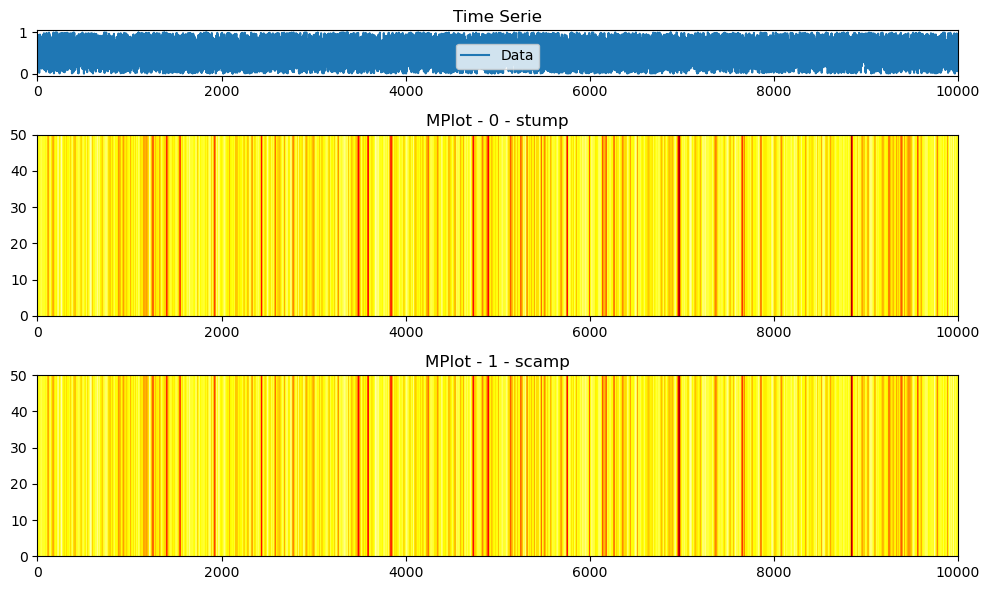

In [5]:
mps.plot([])

### Ejemplo de STUMPY Basics - Analyzing Motifs and Anomalies with STUMP and SCAMP
https://stumpy.readthedocs.io/en/latest/Tutorial_The_Matrix_Profile.html

In [6]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as dates
from matplotlib.patches import Rectangle
import datetime as dt

plt.style.use('https://raw.githubusercontent.com/TDAmeritrade/stumpy/main/docs/stumpy.mplstyle')

In [7]:
steam_df = pd.read_csv("https://zenodo.org/record/4273921/files/STUMPY_Basics_steamgen.csv?download=1")
steam_df.head()

,drum pressure,excess oxygen,water level,steam flow
0,320.08239,2.506774,0.032701,9.302970
1,321.71099,2.545908,0.284799,9.662621
2,320.91331,2.360562,0.203652,10.990955
3,325.00252,0.027054,0.326187,12.430107
4,326.65276,0.285649,0.753776,13.681666


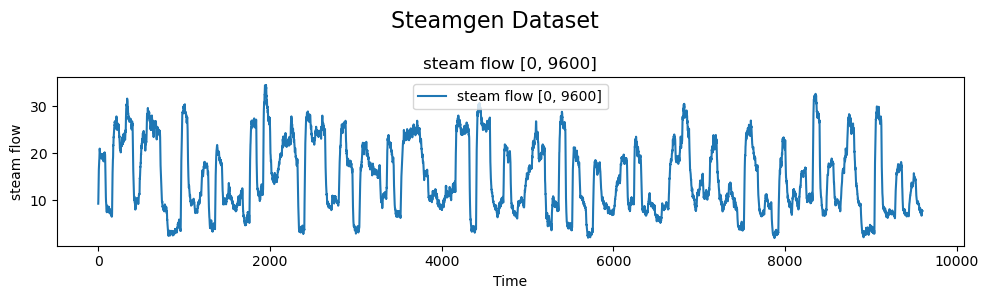

In [8]:
mp.plot_dataFrame('Steamgen Dataset', steam_df, [3])

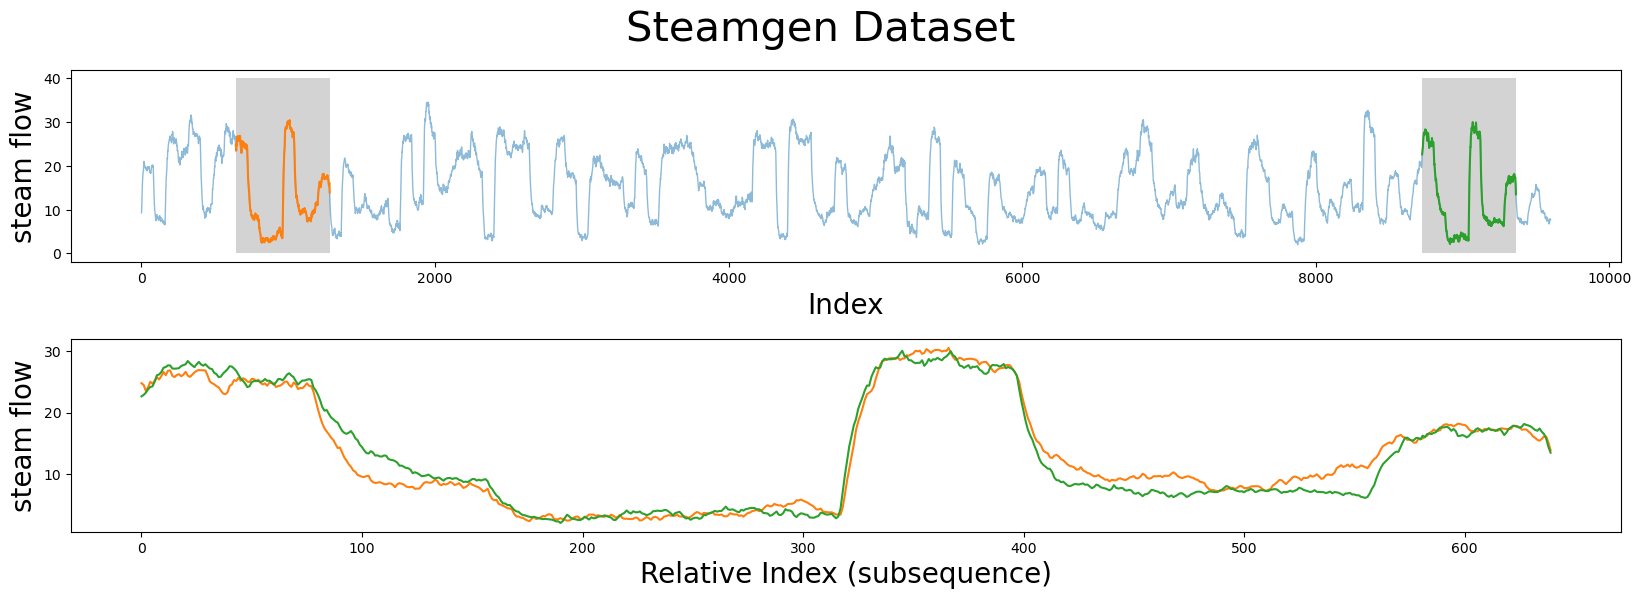

In [9]:
mp.plot_dataFrame_compareSubsequences('Steamgen Dataset', steam_df, 3, 640, 643, 8724)

In [10]:
steam_mps = mp.MatrixProfiles()
steam_mps.subsequence_len = 640
steam_mps.data = steam_df['steam flow']
steam_mps.compute('stump', print_flag = False, debug = False, timed = True)
steam_mps.compute('scamp', print_flag = False, debug = False, timed = True)

/usr/local/share/miniconda3/envs/env/lib/python3.10/site-packages/numba/cuda/dispatcher.py:536: NumbaPerformanceWarning: Grid size 18 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


MatrixProfile(matrix_profile=array([16.23541  , 16.081919 , 15.909404 , ...,  9.02293  ,  9.0382595,
        9.054692 ], dtype=float32), index=array([2242, 2243, 2245, ...,  877,  878,  879], dtype=int32), index_left=[], index_right=[], computation_time=0.1200418472290039, subsequence_len=640, method='scamp', motif_idx=0, motif_nearest_neighbor_idx=0, motif_nearest_neighbor_idx_left=0, motif_nearest_neighbor_idx_right=0, discord_idx=0, discord_nearest_neighbor_idx=0, discord_nearest_neighbor_idx_left=0, discord_nearest_neighbor_idx_right=0)

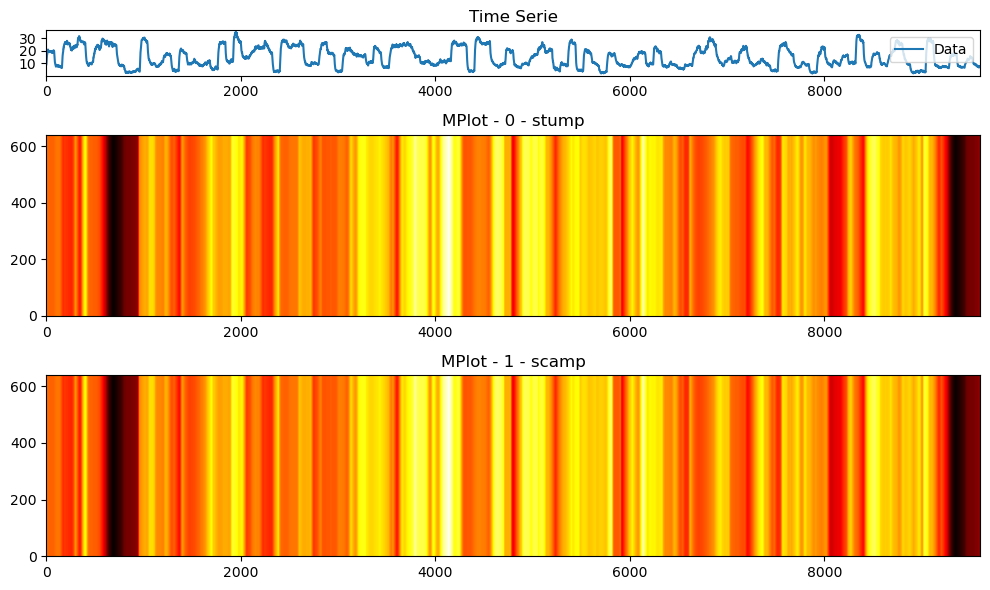

In [11]:
steam_mps.plot()

In [12]:
print("Ts ~ ", steam_mps.data.shape)
print("Expected mp length: ", int(np.floor(steam_mps.data.shape[0]-steam_mps.subsequence_len+1)))
print("mp_stumpy ~", steam_mps.matrix_profiles[0].matrix_profile.shape)
print("mp_scamp ~", steam_mps.matrix_profiles[1].matrix_profile.shape)
print(steam_mps.matrix_profiles[0])
print(steam_mps.matrix_profiles[1])

Ts ~  (9600,)
Expected mp length:  8961
mp_stumpy ~ (8961,)
mp_scamp ~ (8961,)
MP: [16.23541147724788 16.081918663230628 15.909403017873382 ...
 9.022931372214835 9.038259675949162 9.054692514421182]
Ids: [2242 2243 2245 ... 877 878 879]
Ids_left: [-1 -1 -1 ... 877 878 879]
Ids_right: [2242 2243 2245 ... -1 -1 -1]
Computation_time: 2.8843586444854736
subsequence_len: 640
method: stump
MP: [16.23541   16.081919  15.909404  ...  9.02293    9.0382595  9.054692 ]
Ids: [2242 2243 2245 ...  877  878  879]
Ids_left: []
Ids_right: []
Computation_time: 0.1200418472290039
subsequence_len: 640
method: scamp


In [13]:
stumpy_idxs = steam_mps.get_motif_idx(0)
scamp_idxs = steam_mps.get_motif_idx(1)

In [14]:
print(f"The motif (according to stumpy) is located at index {stumpy_idxs[0]}")
print(f"The motif (according to scamp) is located at index {scamp_idxs[0]}")

The motif (according to stumpy) is located at index 643
The motif (according to scamp) is located at index 8724


### --> Tiene sentido que haya salido diferente por tema de decimales... 
> ¿Serán vecinos?

In [15]:
print(f"The nearest neighbor (stumpy) is located at index {stumpy_idxs[1]}")
print(f"The nearest neighbor (scamp) is located at index {scamp_idxs[1]}")

The nearest neighbor (stumpy) is located at index 8724
The nearest neighbor (scamp) is located at index 643


¡Son los vecinos más cercanos en ambos casos!
De hecho, si imprimimos los valores, la z-distancia euclídea es la misma hasta donde podemos ver...

In [16]:
print( steam_mps.matrix_profiles[1].matrix_profile[stumpy_idxs[0]])
print( steam_mps.matrix_profiles[1].matrix_profile[stumpy_idxs[1]])
print( steam_mps.matrix_profiles[0].matrix_profile[scamp_idxs[0]])
print( steam_mps.matrix_profiles[0].matrix_profile[scamp_idxs[1]])

5.4916167
5.4916167
5.491619827769913
5.491619827769913


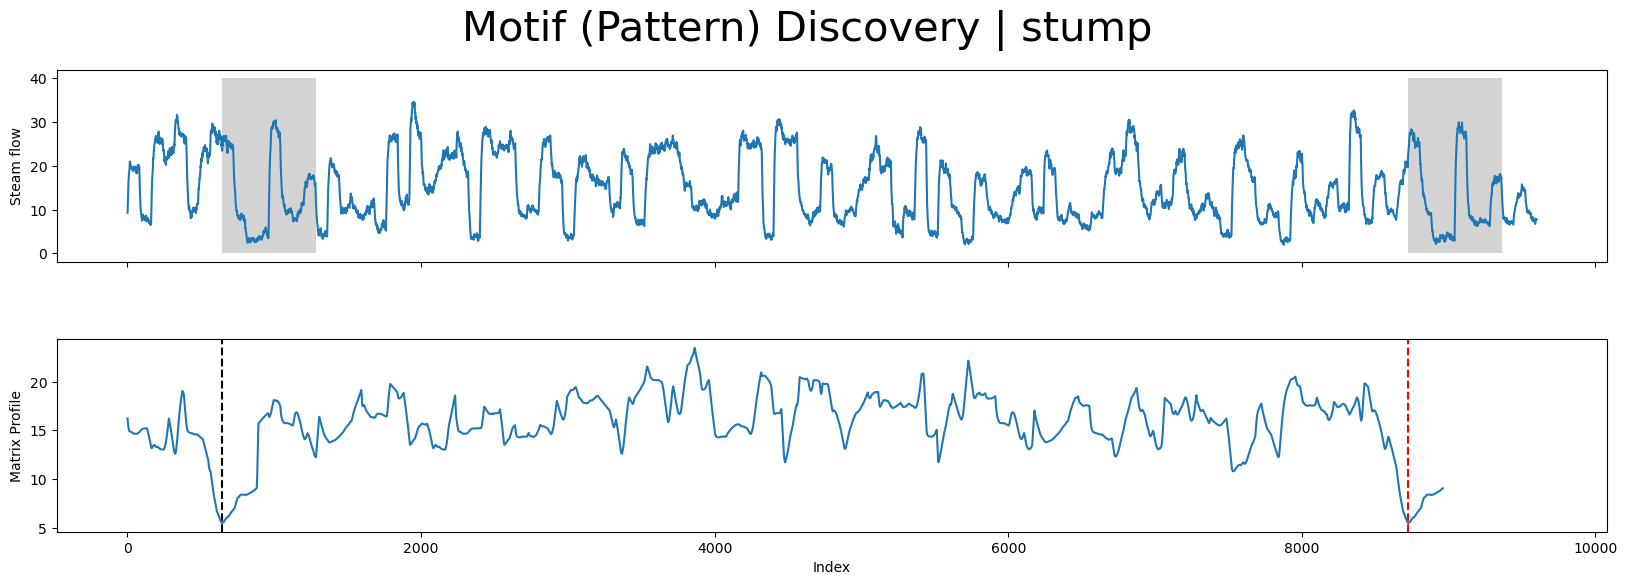

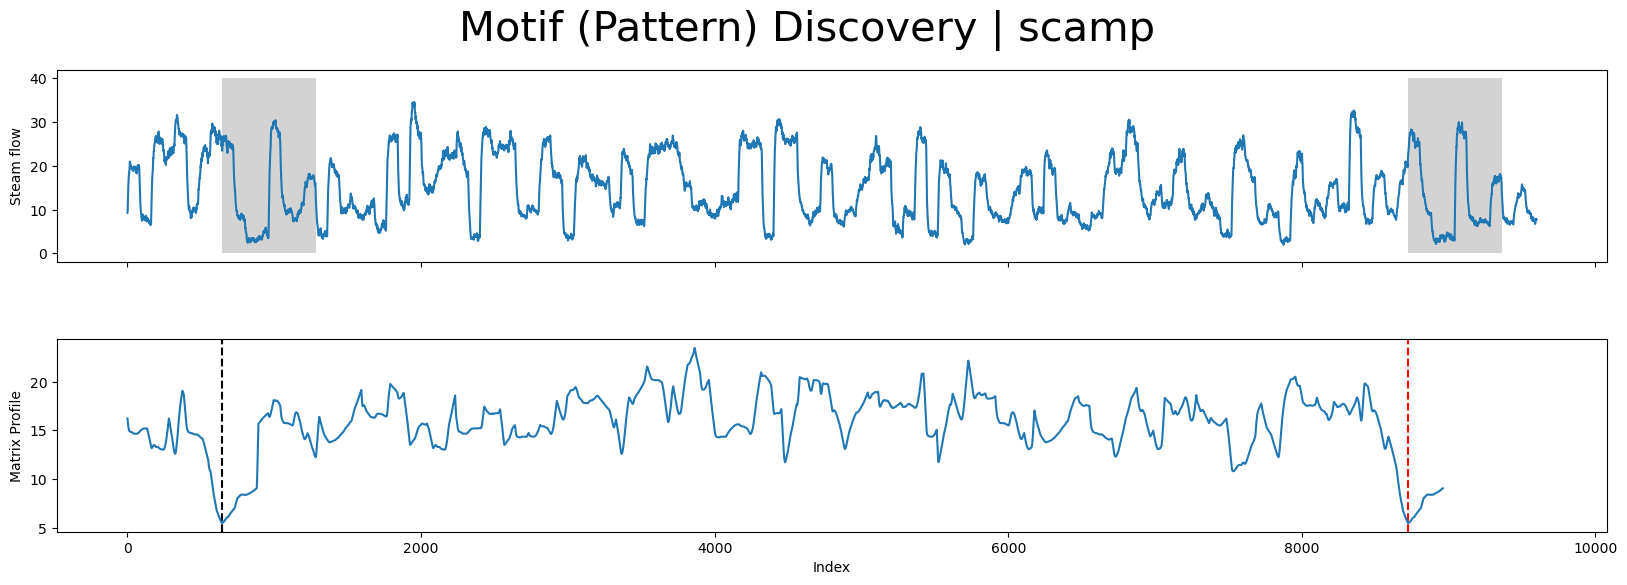

In [17]:
steam_mps.plot_motif('Steam flow', 0, stumpy_idxs[0], stumpy_idxs[1], '30', '10')
steam_mps.plot_motif('Steam flow', 1, stumpy_idxs[0], stumpy_idxs[1], '30', '10')

## Discord / Anomaly

In [18]:
#mp_stumpy_sorted = np.argsort( steam_mps.matrix_profiles[0].matrix_profile )
#mp_scamp_sorted =  np.argsort( steam_mps.matrix_profiles[1].matrix_profile )

#discord_idx_stumpy = mp_stumpy_sorted[-1]

#discord_idx_scamp = mp_scamp_sorted[-1]
#print( steam_mps.matrix_profiles[1].matrix_profile[stumpy_idxs[0]])
steam_mps.get_anomaly_idx(0)
steam_mps.get_anomaly_idx(1)
discord_idx_stumpy = steam_mps.matrix_profiles[0].discord_idx
discord_idx_scamp = steam_mps.matrix_profiles[1].discord_idx
print(f"Stumpy: The discord is located at index {discord_idx_stumpy}")
print(f"Scamp: The discord is located at index {discord_idx_scamp}")

Stumpy: The discord is located at index 3864
Scamp: The discord is located at index 3864


In [19]:
print("Stumpy | Discord: [", steam_mps.matrix_profiles[0].matrix_profile[discord_idx_stumpy],",", steam_mps.matrix_profiles[0].index[discord_idx_stumpy], "]")
print("Scamp |  Discord: [", steam_mps.matrix_profiles[1].matrix_profile[discord_idx_scamp], ",",steam_mps.matrix_profiles[1].index[discord_idx_scamp], "]")

Stumpy | Discord: [ 23.476168367301856 , 4755 ]
Scamp |  Discord: [ 23.476168 , 4755 ]


The subsequence located at this global maximum is also referred to as a discord, novelty, or “potential anomaly”:

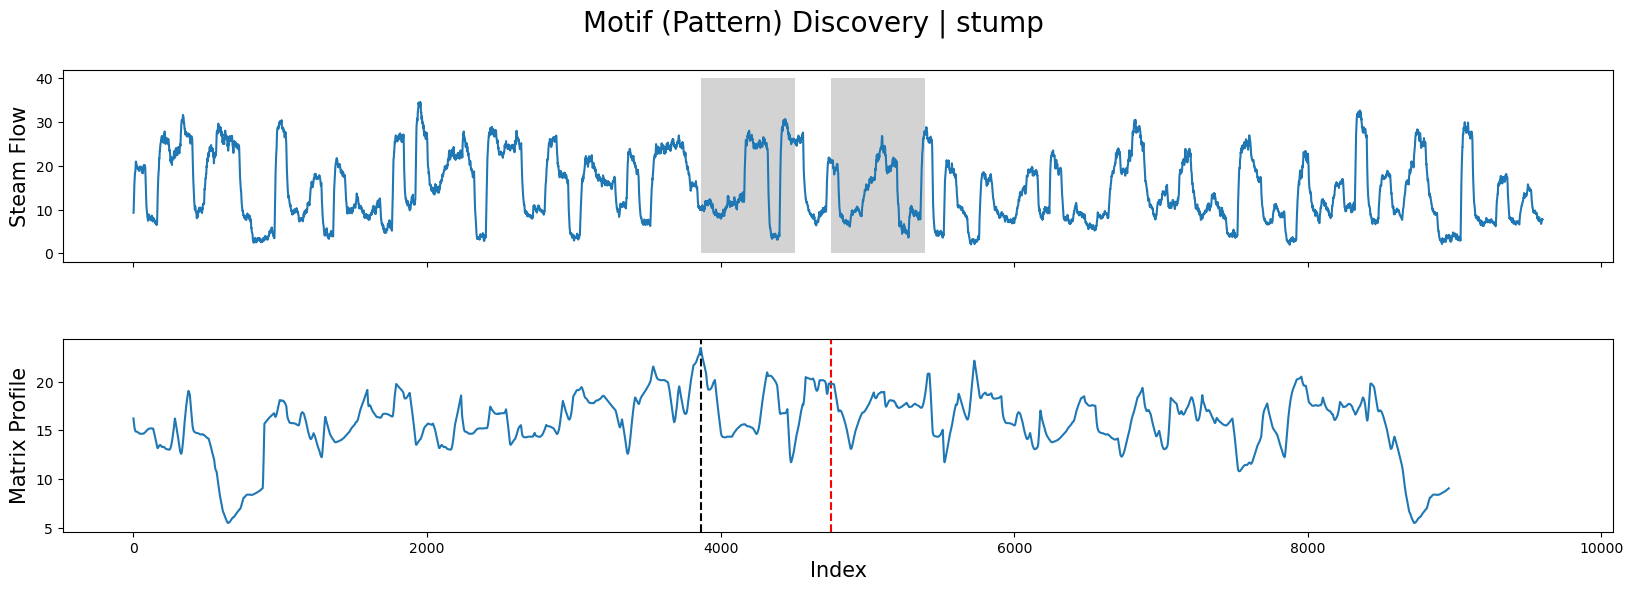

In [20]:
steam_mps.plot_motif(
    'Steam Flow', 
    0, 
    steam_mps.matrix_profiles[0].discord_idx, 
    steam_mps.matrix_profiles[0].discord_nearest_neighbor_idx, 
    '20',
    '15'
)

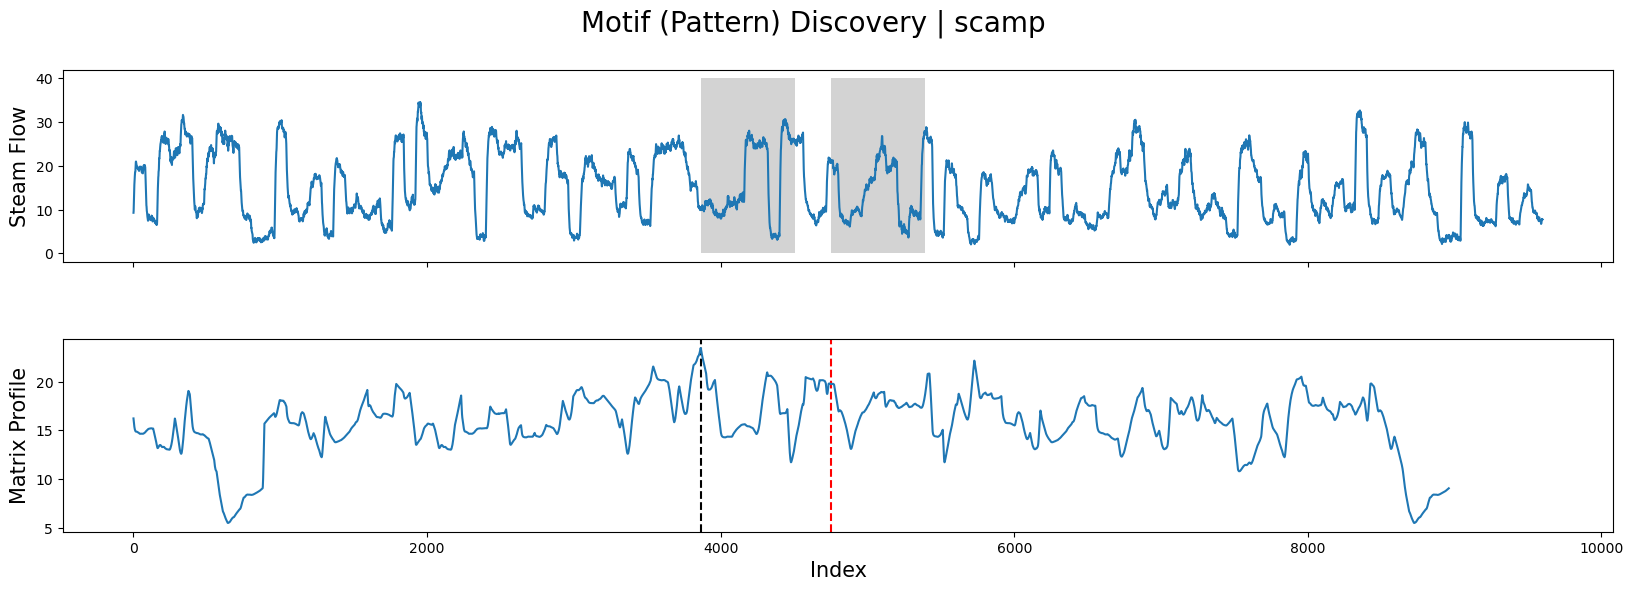

In [21]:
steam_mps.plot_motif(
    'Steam Flow', 
    1, 
    steam_mps.matrix_profiles[1].discord_idx, 
    steam_mps.matrix_profiles[1].discord_nearest_neighbor_idx, 
    '20',
    '15'
)

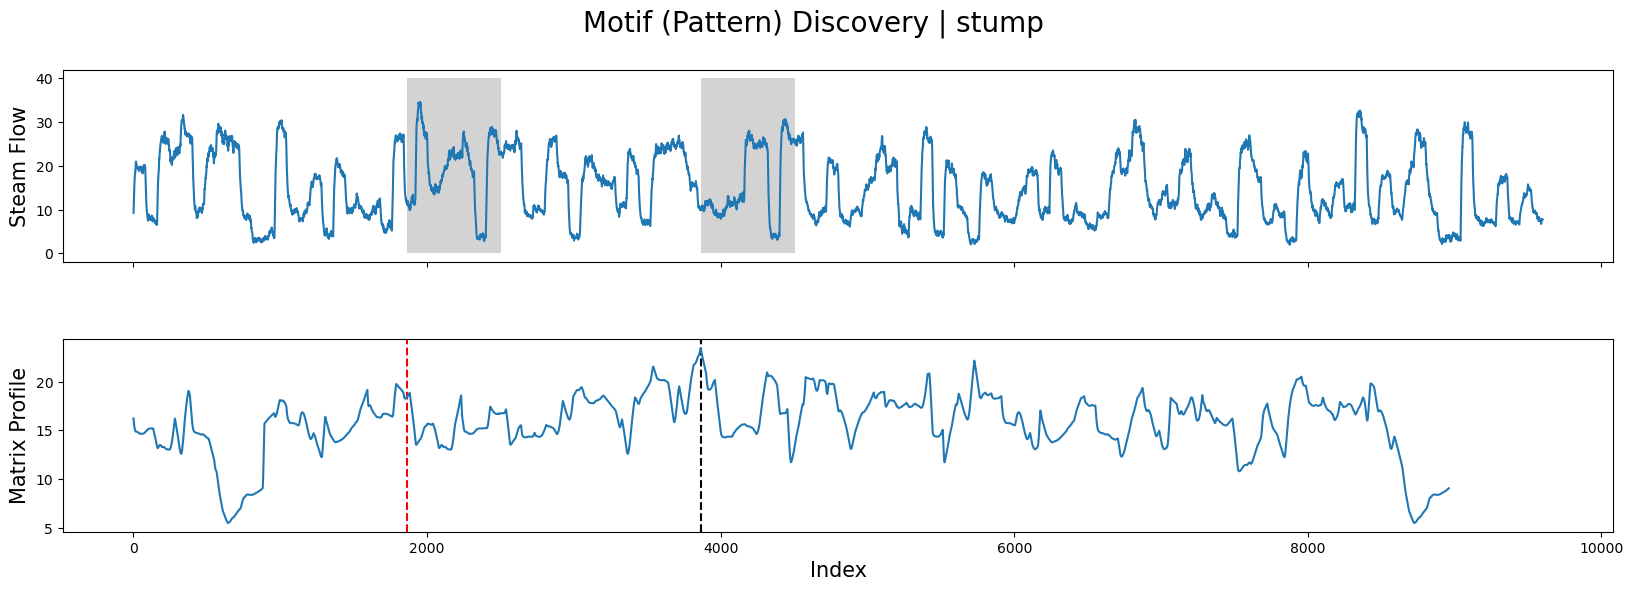

In [22]:
steam_mps.plot_motif(
    'Steam Flow', 
    0, 
    steam_mps.matrix_profiles[0].discord_idx, 
    steam_mps.matrix_profiles[0].discord_nearest_neighbor_idx_left, 
    '20',
    '15'
)

Intentando ver la matriz Distance Profile al completo

In [23]:
steam_flow = steam_df['steam flow'].values
#No nans
steam_flow = [ 0 if np.isnan(x) else x for x in steam_flow ]

## Cogiendo Distance Matrix al completo 
> En busca del MPlot

In [24]:
steam_mps.data
steam_mps.subsequence_len
# Ensure no nans 
steam_mps.data = [ 0 if np.isnan(x) else x for x in steam_mps.data ]

In [25]:
#n = len(steam_flow) 
#subsequence_len = m
#print("Expected: ", len(steam_flow) - m + 1)

In [26]:
#MPlot_matrix_stumpy = np.empty((n - m + 1, n - m + 1))
#MPlot_matrix_scamp = np.empty((n - m + 1, n - m + 1))

In [27]:
mplot_stumpy = mp.MatrixProfilePlot(data = steam_mps.data, subsequence_len = steam_mps.subsequence_len)
mplot_scamp  = mp.MatrixProfilePlot(data = steam_mps.data, subsequence_len = steam_mps.subsequence_len)

In [28]:
reference_idx = np.random.randint(low=0, high=len(steam_flow) - steam_mps.subsequence_len)
reference_subseq = steam_flow[reference_idx:reference_idx + steam_mps.subsequence_len]

### Calcular el Distance Profile para cada subsecuencia en la serie temporal respecto a la secuencia de referencia

In [37]:
mplot_stumpy.compute_similarity_matrix(
    subsequence_len = mplot_stumpy.subsequence_len,
    reference_seq   = reference_subseq,
    method          = 'stump',
    timed           = True,
    print_flag      = True
)

--> Stump
matrix profile 8.726007461547852 seconds -->


array([[30.75824853, 30.75824853, 30.75824853, ..., 30.75824853,
        30.75824853, 30.75824853],
       [30.87172734, 30.87172734, 30.87172734, ..., 30.87172734,
        30.87172734, 30.87172734],
       [30.99414915, 30.99414915, 30.99414915, ..., 30.99414915,
        30.99414915, 30.99414915],
       ...,
       [40.50402154, 40.50402154, 40.50402154, ..., 40.50402154,
        40.50402154, 40.50402154],
       [40.40189069, 40.40189069, 40.40189069, ..., 40.40189069,
        40.40189069, 40.40189069],
       [40.29856959, 40.29856959, 40.29856959, ..., 40.29856959,
        40.29856959, 40.29856959]])

In [38]:
mplot_scamp.compute_similarity_matrix(
    subsequence_len = mplot_stumpy.subsequence_len,
    reference_seq   = reference_subseq,
    method          = 'scamp',
    timed           = True,
    print_flag      = True
)

--> Scamp
matrix profile 127.72573637962341 seconds -->


array([[30.75824928, 30.75824928, 30.75824928, ..., 30.75824928,
        30.75824928, 30.75824928],
       [30.87172699, 30.87172699, 30.87172699, ..., 30.87172699,
        30.87172699, 30.87172699],
       [30.99414825, 30.99414825, 30.99414825, ..., 30.99414825,
        30.99414825, 30.99414825],
       ...,
       [40.50402069, 40.50402069, 40.50402069, ..., 40.50402069,
        40.50402069, 40.50402069],
       [40.4018898 , 40.4018898 , 40.4018898 , ..., 40.4018898 ,
        40.4018898 , 40.4018898 ],
       [40.29856873, 40.29856873, 40.29856873, ..., 40.29856873,
        40.29856873, 40.29856873]])

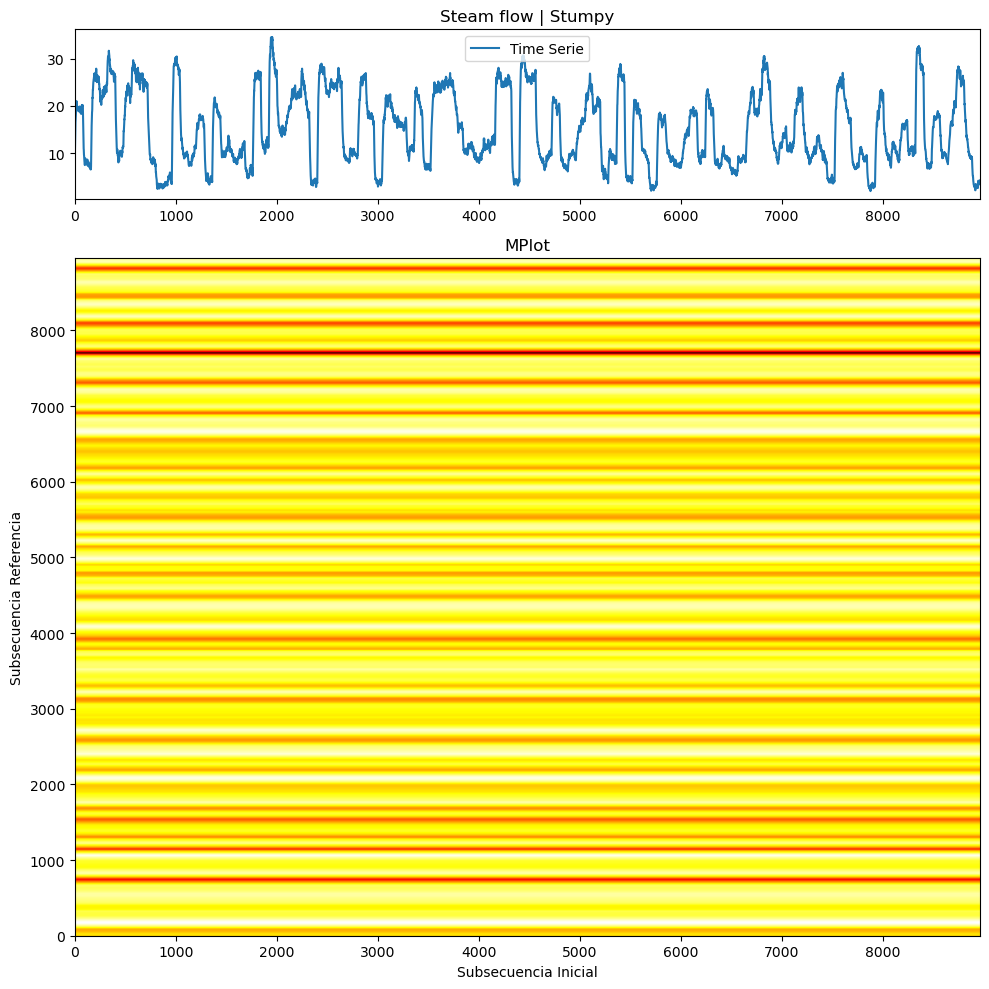

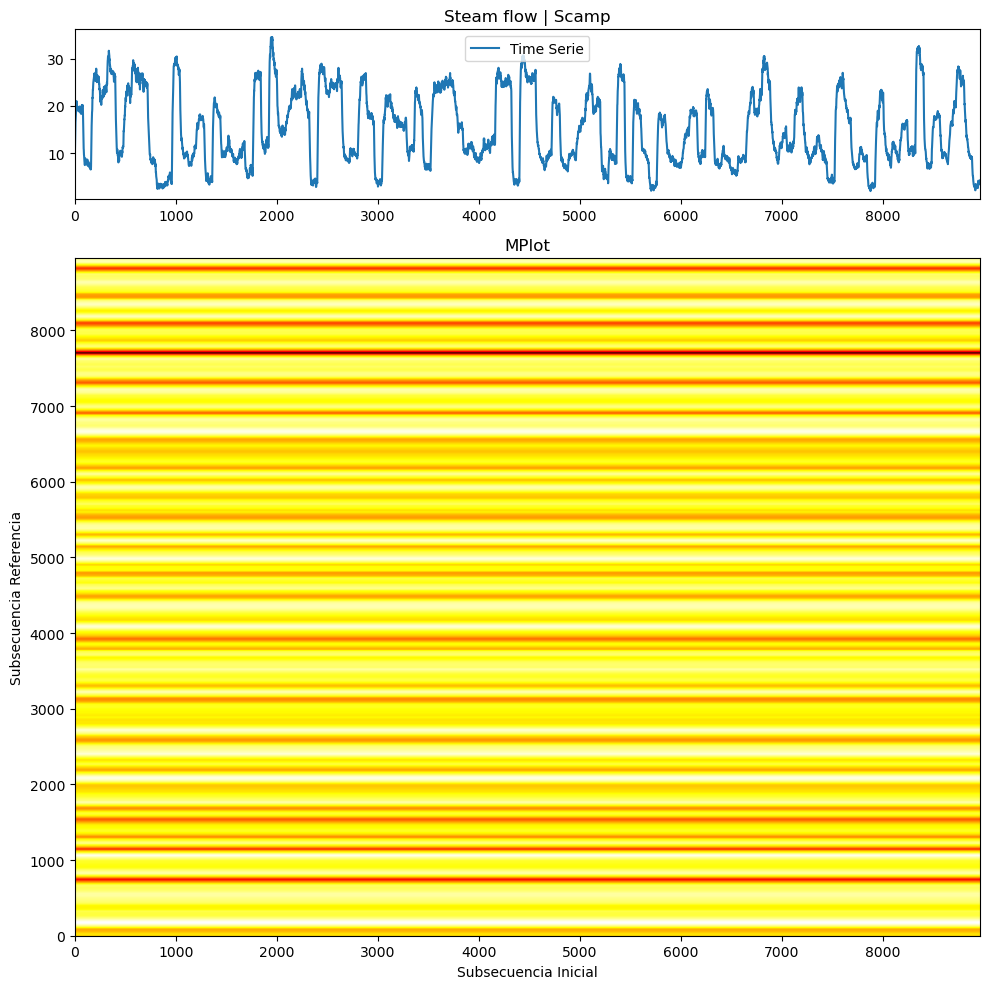

In [39]:
mplot_stumpy.plot('Steam flow', "Stumpy")
mplot_scamp.plot('Steam flow', "Scamp")

### Calcular el Distance Profile para cada subsecuencia en la serie temporal al completo

In [29]:
mplot_stumpy.compute_similarity_matrix(
    subsequence_len = mplot_stumpy.subsequence_len,
    #reference_seq   = reference_subseq,
    reference_seq   = None,
    method          = 'stump',
    timed           = True,
    print_flag      = True
)

--> Stump
matrix profile 54.96991205215454 seconds -->


array([[5.33120150e-07, 1.74846009e+00, 3.04914479e+00, ...,
        4.18138659e+01, 4.18354133e+01, 4.18458759e+01],
       [1.74846009e+00, 0.00000000e+00, 1.75154454e+00, ...,
        4.18403902e+01, 4.18724627e+01, 4.18945617e+01],
       [3.04914479e+00, 1.75154454e+00, 0.00000000e+00, ...,
        4.18543632e+01, 4.18968496e+01, 4.19294621e+01],
       ...,
       [4.18138659e+01, 4.18403902e+01, 4.18543632e+01, ...,
        5.33120150e-07, 1.54486633e+00, 2.82499346e+00],
       [4.18354133e+01, 4.18724627e+01, 4.18968496e+01, ...,
        1.54486633e+00, 0.00000000e+00, 1.54582989e+00],
       [4.18458759e+01, 4.18945617e+01, 4.19294621e+01, ...,
        2.82499346e+00, 1.54582989e+00, 5.33120150e-07]])

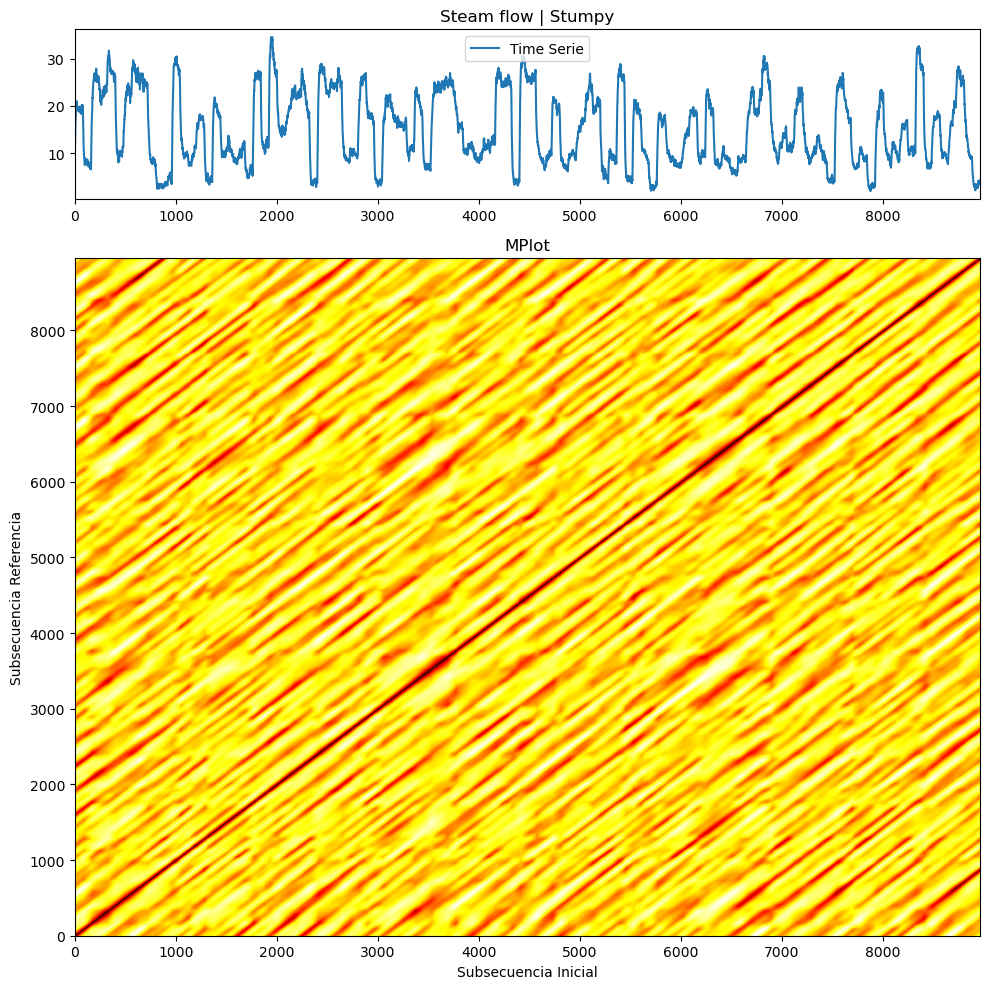

In [30]:
mplot_stumpy.plot('Steam flow', "Stumpy")

In [31]:
mplot_scamp.compute_similarity_matrix(
    subsequence_len = mplot_stumpy.subsequence_len,
    reference_seq   = None, #reference_subseq,
    method          = 'scamp',
    timed           = True,
    print_flag      = True
)

--> Scamp
Validating SCAMP args.
--> Complete  (8961, 8961)
matrix profile 6.392603158950806 seconds -->
Building SCAMP Operation from args
SCAMP Operation constructed
Num workers = 48
Precomputing statisics on the CPU.
Precomputation took 0.000347 seconds.
num_tile_rows = 14, cols = 14
Performing join with 105 tiles.
Main SCAMP thread spawning worker threads.
Starting tile with starting row of 0 starting column of 0 with height 1280 and width 1280
Launching AVX2 kernel.
Starting tile with starting row of 641 starting column of 641 with height 1280 and width 1280
Launching AVX2 kernel.
Starting tile with starting row of 1282 starting column of 1282 with height 1280 and width 1280
Launching AVX2 kernel.
Starting tile with starting row of 1923 starting column of 1923 with height 1280 and width 1280
Launching AVX2 kernel.
Starting tile with starting row of 2564 starting column of 2564 with height 1280 and width 1280
Launching AVX2 kernel.
Starting tile with starting row of 3205 starting c

array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float32)

th height 1280 and width 1280
Launching AVX2 kernel.
Launching AVX2 kernel.
Starting tile with starting row of 1282 starting column of 1923 with height 1280 and width 1280
Launching AVX2 kernel.
Launching AVX2 kernel.
Starting tile with starting row of 1923 starting column of 2564 with height 1280 and width 1280
Launching AVX2 kernel.
Launching AVX2 kernel.
Starting tile with starting row of 2564 starting column of 3205 with height 1280 and width 1280
Launching AVX2 kernel.
Launching AVX2 kernel.
Starting tile with starting row of 3205 starting column of 3846 with height 1280 and width 1280
Launching AVX2 kernel.
Launching AVX2 kernel.
Starting tile with starting row of 3846 starting column of 4487 with height 1280 and width 1280
Launching AVX2 kernel.
Launching AVX2 kernel.
Starting tile with starting row of 4487 starting column of 5128 with height 1280 and width 1280
Launching AVX2 kernel.
Launching AVX2 kernel.
Starting tile with starting row of 5128 starting column of 5769 with hei

In [32]:
print(len(steam_flow))
print(mplot_stumpy.similarity_matrix.shape)
print(mplot_scamp.similarity_matrix.shape)

9600
(8961, 8961)
(8961, 8961)


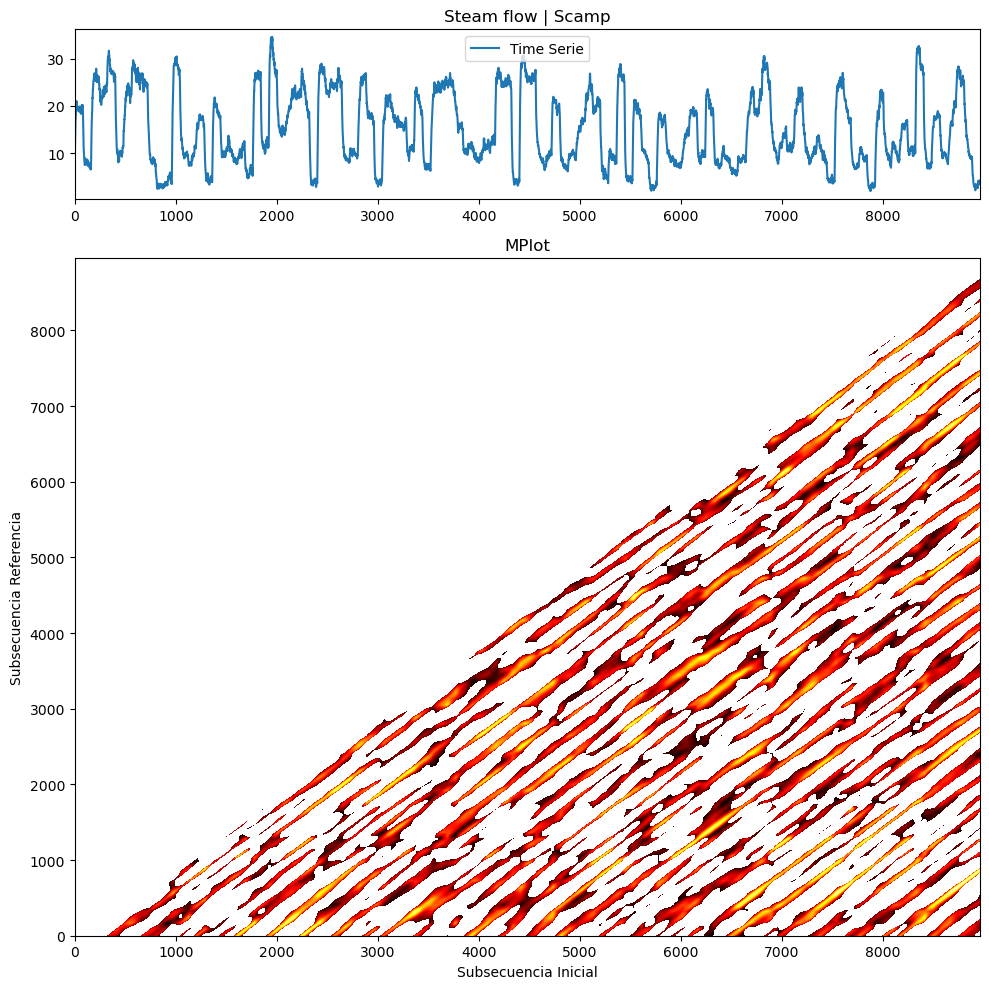

In [33]:
mplot_scamp.plot('Steam flow', "Scamp")